In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
# !pip install bbox
from bbox import *
from pytz import timezone
import xarray as xr
# import gcsfs
import os
from shapely.wkt import loads
import numpy as np
import xarray as xr
import gc
import re
import requests
import json
import sys
from google.cloud import storage
from io import StringIO
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = pd.to_datetime(no2_hours)

In [5]:
# Extract month, day, and hour
month_day_hour = time_list.strftime("%m-%d-%H")
month_day_hour_list = month_day_hour.tolist()

In [6]:
def clean_column_names(df):
    # Convert column names to lowercase
    df.columns = [col.strip().lower() for col in df.columns]

    # Replace spaces with underscores
    df.columns = [col.replace(" ", "_") for col in df.columns]

    # Remove any non-alphanumeric characters (except underscores)
    df.columns = [re.sub(r'[^a-z0-9_]', '', col) for col in df.columns]

    return df

In [7]:
facility = pd.read_csv("../../data/facility_data/facility_map.csv")
la = pd.read_csv("../../data/facility_data/raw/emissions-hourly-2023-la.csv")
tx = pd.read_csv("../../data/facility_data/raw/emissions-hourly-2023-tx.csv")
gridded_csv = pd.read_csv("../../data/facility_data/gridded_combined.csv")

facility = clean_column_names(facility)
la = clean_column_names(la)
tx = clean_column_names(tx)

columns_to_remove = [
    # 'so2_mass_lbs',
    'so2_mass_measure_indicator',
    'so2_rate_lbsmmbtu',
    'so2_rate_measure_indicator',
    # 'co2_mass_short_tons',
    'co2_mass_measure_indicator',
    'co2_rate_short_tonsmmbtu',
    'co2_rate_measure_indicator'
    ,'so2_controls'
    ,'pm_controls'
    ,'hg_controls'
]
la = la.drop(columns=columns_to_remove,errors='ignore')
tx = tx.drop(columns=columns_to_remove,errors='ignore')


/var/tmp/ipykernel_26745/478929260.py:2: DtypeWarning: Columns (3,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  la = pd.read_csv("../../data/facility_data/raw/emissions-hourly-2023-la.csv")
/var/tmp/ipykernel_26745/478929260.py:3: DtypeWarning: Columns (3,4,11,13,15,17,19,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  tx = pd.read_csv("../../data/facility_data/raw/emissions-hourly-2023-tx.csv")
/var/tmp/ipykernel_26745/478929260.py:4: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  gridded_csv = pd.read_csv("../../data/facility_data/gridded_combined.csv")


In [8]:
emissions = pd.concat([la, tx], ignore_index=True)

emissions['date'] = pd.to_datetime(emissions['date'])
emissions['timestamp'] = emissions['date'] + pd.to_timedelta(emissions['hour'], unit='h')
# Make sure 'timestamp' is in datetime format
emissions['timestamp'] = pd.to_datetime(emissions['timestamp'])

gdf = gpd.GeoDataFrame(
    facility,
    geometry=[Point(xy) for xy in zip(facility["longitude"], facility["latitude"])],
    crs="EPSG:4326"  # WGS84 coordinate reference system
)
gdf=gdf[['latitude','longitude','geometry']].drop_duplicates()

# Create gridded GDF
res = 0.01
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x

key = gpd.sjoin(grid_gdf, gdf, how="left", predicate="intersects")
key=key[['geometry','lat','lon','latitude','longitude']]

facility = facility[['facility_id','unit_id','latitude','longitude']]
emissions = pd.merge(emissions, facility, on=['facility_id','unit_id'], how='inner')

# #check to see if there are any duplicates
# print("The length before dupe check", len(emissions_joined))
# emissions_joined = emissions_joined.drop_duplicates(subset=['facility_id', 'unit_id', 'latitude', 'longitude', 'timestamp'])
# print("The length after dupe check", len(emissions_joined))

columns_to_convert = [
    'associated_stacks', 'nox_mass_measure_indicator',
    'nox_rate_measure_indicator', 'heat_input_measure_indicator', 'secondary_fuel_type',
    'nox_controls'
]

# Convert specified columns to strings
for col in columns_to_convert:
    emissions[col] = emissions[col].astype(str)

emissions = emissions[['timestamp', 'latitude','longitude',
                                     'operating_time','gross_load_mw','steam_load_1000_lbhr',
                                     'nox_mass_lbs','so2_mass_lbs','co2_mass_short_tons',
                                     'nox_rate_lbsmmbtu','heat_input_mmbtu']]

emissions['timestamp'] = pd.to_datetime(emissions['timestamp'])

emissions['date'] = emissions['timestamp'].dt.date
emissions['hour'] = emissions['timestamp'].dt.hour
emissions['month_day_hour'] = emissions['timestamp'].dt.strftime("%m-%d-%H")

del la
del tx
del facility

emissions = pd.merge(emissions, key, how='left', on=['latitude','longitude'])
emissions = emissions.drop(columns='geometry')

emissions['lat']=round(emissions['lat'],3)
emissions['lon']=round(emissions['lon'],3)

emissions = emissions.groupby(['timestamp', 'month_day_hour', 'lat', 'lon']).agg({
    'operating_time': 'sum',
    'gross_load_mw': 'sum',
    'steam_load_1000_lbhr': 'sum',
    'nox_mass_lbs': 'sum',
    'so2_mass_lbs': 'sum',
    'co2_mass_short_tons': 'sum',
    # 'nox_rate_lbsmmbtu': 'mean',
    'heat_input_mmbtu': 'sum'
}).reset_index()

# set leap year dates as the dates from 2/28
leap_year = emissions[emissions['month_day_hour'].str[:5]=='02-28']
leap_year['month_day_hour'] = '02-29' + emissions['month_day_hour'].str[5:]
emissions = pd.concat([emissions, leap_year])
emissions = emissions[emissions['month_day_hour'].isin(month_day_hour_list)]

# # Convert emissions['month_day_hour'] to a set
# emissions_set = set(emissions['month_day_hour'].unique())

# # Find the times in month_day_hour_list that are not in emissions
# missing_times = set(month_day_hour_list) - emissions_set

# print("Missing times:", missing_times)
# print(f"Number of missing times: {len(missing_times)}")

/var/tmp/ipykernel_26745/2811570733.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lat"] = grid_gdf.geometry.centroid.y
/var/tmp/ipykernel_26745/2811570733.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lon"] = grid_gdf.geometry.centroid.x
/var/tmp/ipykernel_26745/2811570733.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leap_year['month_day_hour'] = '02-29' + emissions['month_day_hour'].str[5:]


In [11]:
unique_months = time_list.to_period('M').unique()
unique_months[17]

Period('2025-01', 'M')

In [12]:
%%capture
unique_months = time_list.to_period('M').unique()

for month in unique_months[17:18]:
    month_str = str(month)
    month_timestamps = time_list[time_list.to_period('M') == month]
    monthly_xr_list = []
    
    for ts in month_timestamps:
        ts_mdh = ts.strftime("%m-%d-%H")

        emissions_ts = emissions[emissions['month_day_hour']==ts_mdh]

        grid_gdf['lat'] = round(grid_gdf['lat'], 3)
        grid_gdf['lon'] = round(grid_gdf['lon'], 3)
        emissions_ts['lat'] = round(emissions_ts['lat'], 3)
        emissions_ts['lon'] = round(emissions_ts['lon'], 3)
        emissions_grid_ts= pd.merge(grid_gdf, emissions_ts, how='left', on = ['lat','lon'])

        emissions_grid_ts['month_day_hour'] = emissions_grid_ts['month_day_hour'].fillna(ts_mdh)
        emissions_grid_ts = emissions_grid_ts.drop(columns='timestamp')
        emissions_grid_ts=emissions_grid_ts.fillna(0)
        emissions_grid_ts = emissions_grid_ts.drop(columns='geometry')

        prep_df = emissions_grid_ts[['lat','lon','nox_mass_lbs']]
        # Step 1: Pivot the DataFrame
        df_pivot = prep_df.pivot(index="lat", columns="lon", values="nox_mass_lbs")

        # Step 2: Convert to xarray DataArray
        data_array = xr.DataArray(
            df_pivot.values,
            dims=["lat", "lon"],
            coords={"lat": df_pivot.index, "lon": df_pivot.columns},
        )

        # Step 3: Convert to xarray Dataset (optional)
        dataset = data_array.to_dataset(name="nox_mass_lbs")

        other_variables = ['gross_load_mw', 'steam_load_1000_lbhr',
               'so2_mass_lbs', 'co2_mass_short_tons',
               'heat_input_mmbtu']

        for var in other_variables:
            prep_df = emissions_grid_ts[['lat','lon',var]]
            # Step 1: Pivot the DataFrame
            df_pivot = prep_df.pivot(index="lat", columns="lon", values=var)

            # Step 2: Convert to xarray DataArray
            data_array = xr.DataArray(
                df_pivot.values,
                dims=["lat", "lon"],
                coords={"lat": df_pivot.index, "lon": df_pivot.columns},
            )
            dataset[var] = data_array

        dataset = dataset.expand_dims({'time': [ts]})

        monthly_xr_list.append(dataset)

    combined_data = xr.concat(monthly_xr_list, dim='time')

    combined_data.to_netcdf(f'../../data/emissions/emissions_{month_str}.nc')

PermissionError: [Errno 13] Permission denied: '/home/jupyter/data/emissions/emissions_2025-01.nc'

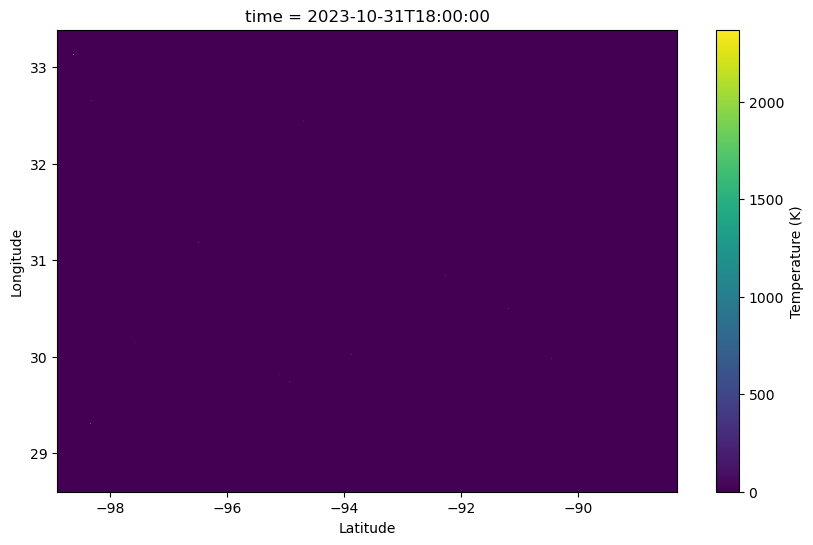

In [8]:
import matplotlib.pyplot as plt
# # # Define your latitude and longitude bounds
# # lat_min, lat_max = 28.6, 33.4  # Example latitude range
# # lon_min, lon_max = -98.9, -88.3  # Example longitude range

# # Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 1  # Change this to select a different hour if desired
# # temperature_data = nldas_month['temperature'].isel(time=hour_index)
# temperature_data = nldas_month['wind_u']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
dataset['nox_mass_lbs'][0].plot(
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()

In [9]:
test

NameError: name 'test' is not defined